In [1]:
import os
import cv2
import glob
import torch
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import math
from collections import defaultdict
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from matplotlib.patches import Rectangle

In [2]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.masks = {}
        
        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # Store tumor type in self.labels (0 = nonrecurrent, 1 = recurrent)
        for i, img in enumerate(self.image_files):
            mask_name = img.split("/")[-1].split("_")[0]
            slide_num = mask_name[:6]
            tissue_num = mask_name[6:]
            img = Image.open(img)
            w, h = img.size
            if mask_name not in self.masks:
                self.masks[mask_name] = np.zeros((h, w, 3), dtype=np.uint8)
            else:
                
                both_zero_mask = (np.array(img) == 0) & (self.masks[mask_name] == 0)
                self.masks[mask_name] = np.where(both_zero_mask, 0, 255).astype(np.uint8)
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        mask_name = self.image_files[idx].split("/")[-1].split("_")[0]
        channel = self.image_files[idx].split("/")[-1][9:20]
        img = Image.open(self.image_files[idx])
        # extract the red channel to make the image grayscale
        r,g,b = img.split()
        image = r
        mask = Image.fromarray(self.masks[mask_name]).convert('L')
        label = self.labels[idx] # corresponding label
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, label, mask, channel  # return image, label, its underlying mask, and its channel (mz mob combination)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert to tensor

])

# create dataset and dataloader
folder_path = '../data/images_3snr_aligned/'
dataset = SingleChannelDataset(folder_path, transform=None)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
def plot_sampled_patches(image, coordinates, patch_size, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of sampled patches.
        width (int): width of the patch.
        height (int): height of the patch.
    """
    image_array = np.array(image)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    for (x_start, y_start) in coordinates:
        top_left = (y_start, x_start)
        bottom_right = (y_start + patch_size, x_start + patch_size)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)

    ax.imshow(image)
    ax.axis('off')
    return ax

In [5]:
def construct_patches(img, width=32, height=32):
    """
    Cuts a PIL Image object into patches and converts each patch to a NumPy array.
    """
    img_array = np.array(img)  # Convert PIL Image to NumPy array
    patches = []
    for i in range(0, img_array.shape[0], width):  # Iterate over rows
        for j in range(0, img_array.shape[1], height):  # Iterate over columns
            if img_array.ndim == 2:
                patch = img_array[i:i + width, j:j + height]
            else:
                patch = img_array[i:i + width, j:j + height, :]
            patches.append(patch)
    return patches
    

In [6]:
def quilting_image(patches_a, patches_b, patch_size, percentage_a=0.5):
    """
    Reconstructs an image by randomly picking patches from two lists,
    with a specified percentage of patches coming from list A.

    Args:
        patches_a: A list of NumPy arrays (patches from image A).
        patches_b: A list of NumPy arrays (patches from image B).
        percentage_a: The percentage of patches to be selected from patches_a (default: 0.5).

    Returns:
        A PIL Image object representing the reconstructed image, or None if there's an error.
    """
    
    
    
    if len(patches_a) != len(patches_b):  # patch counts must match
        raise ValueError("Length of both lists must match!")
    
    num_rows = int(math.sqrt(len(patches_a)))  # number of patches per row is square root of length of patch list
    
    try:
        quilted_image = np.zeros((num_rows * patch_size, num_rows * patch_size), dtype=np.uint8)
        patch_index = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # choose between A and B based on percentage_a
                if random.random() < percentage_a:  # random.random() returns a float between 0 and 1
                    chosen_patch = patches_a[patch_index]
                else:
                    chosen_patch = patches_b[patch_index]

                row_start = i * patch_size
                row_end = row_start + patch_size
                col_start = j * patch_size
                col_end = col_start + patch_size
                quilted_image[row_start:row_end, col_start:col_end] = chosen_patch
                patch_index += 1
        
        return Image.fromarray(quilted_image)

    except Exception as e:
        print(f"Error reconstructing image: {e}")
        return None

In [7]:
def create_patched_image(patches, patch_size):
    # Check if we have the right number of arrays
    patches_per_dimension = 224//patch_size
    if len(patches) != patches_per_dimension**2:
        raise ValueError(f"Number of patches  ({len(patches)})cannot be used to form a 224x224 image given patch size {patch_size}")
    
    # Determine if we're working with grayscale or color images
    if len(patches[0].shape) == 3:
        # Color images
        height, width, channels = patches[0].shape
        result = np.zeros((patches_per_dimension * height, patches_per_dimension * width, channels))
    else:
        # Grayscale images
        height, width = patches[0].shape
        result = np.zeros((patches_per_dimension * height, patches_per_dimension * width))
    
    # Place each array in the correct position
    for i in range(patches_per_dimension):
        for j in range(patches_per_dimension):
            index = i * patches_per_dimension + j
            row_start = i * height
            col_start = j * width
            result[row_start:row_start + height, col_start:col_start + width] = patches[index]
    
    return result

In [8]:
def sample_patches(img, max_patches, patch_size, min_distance):
    """
    Randomly sample n coordinates from white regions (value 255) in a binary image.
    
    Args:
        img: PIL Image or numpy array with binary values (0, 255)
        max_patches: maximum number of patches
        patch_size: the size of the patch
        overlap: acceptable overlap between patches
        
    Returns:
        numpy.ndarray: Array of shape (max_patches, 2) containing (x, y) coordinates
    """
    # convert PIL Image to numpy array if needed
    if isinstance(img, Image.Image):
        img_array = np.array(img)
    else:
        img_array = img
            
    # find coordinates of white pixels in the mask image (value 255)
    white_pixels = np.where(img_array == 255)
    all_coords = np.column_stack((white_pixels[0], white_pixels[1]))
    
    # create a set of tuples for faster membership testing
    # note that we use (y,x) format for coordinates since that's how NumPy indexes images
    coords_set = set(map(tuple, all_coords))
    
    # find valid candidate points that have the bottom right coordinate also in white region
    valid_candidates = []
    valid_indices = []
    

    for idx, (y, x) in enumerate(all_coords):
        factor = random.randint(1, 3)
        bottom_right_coord = (y + patch_size*factor, x + patch_size)  # Note: offset is (x,y) but coords are (y,x)
        if bottom_right_coord in coords_set:
            valid_candidates.append((y, x))
            valid_indices.append(idx)
    
    valid_candidates = np.array(valid_candidates)
    
    # check if we have enough white pixels
    if len(valid_candidates) < max_patches:
        raise ValueError(f"Not enough valid candidates ({len(valid_candidates)}) to sample {max_patches} coordinates")
    
    # create a mask that will be updated to 0 in regions where points are already placed
    # we'll start with all 1s where valid points exist
    point_mask = np.zeros_like(img_array, dtype=bool)
    for y, x in valid_candidates:
        point_mask[y, x] = True
        
    # array to store sampled coordinates
    sampled_coords = []
    
    for _ in range(max_patches):
        # if we've eliminated all possible points, break
        if not np.any(point_mask):
            break
            
        # get indices where mask is True (valid points remain)
        remaining_y, remaining_x = np.where(point_mask)
        remaining_indices = np.arange(len(remaining_y))
        
        # shuffle to randomly sample
        np.random.shuffle(remaining_indices)
        
        # try points in random order
        found_point = False
        for idx in remaining_indices:
            y, x = remaining_y[idx], remaining_x[idx]
            
            # if this point and its offset are both valid
            if (y, x) in coords_set and (y + patch_size, x + patch_size) in coords_set:
                sampled_coords.append((y, x))
                found_point = True
                
                # create a circular mask to remove points that are too close
                y_indices, x_indices = np.ogrid[-y:img_array.shape[0]-y, -x:img_array.shape[1]-x]
                dist_mask = y_indices*y_indices + x_indices*x_indices <= min_distance*min_distance
                point_mask[dist_mask] = False
                
                break
        # we couldn't find another valid point        
        if not found_point:
            break
    
    # check if we got enough samples
    if len(sampled_coords) < max_patches:
        print(f"Warning: Could only find {len(sampled_coords)} points with minimum distance {min_distance} between patches.")
    return sampled_coords

In [9]:
def sample_patches_from_mask(mask, patch_size=32, stride=16, overlap_threshold=0.5, min_distance=None):
    """
    Samples rectangular patches from a binary mask array.

    Args:
        mask (np.ndarray): Binary numpy array where nonzero values indicate the region of interest.
        patch_size (int): The size (width and height) of each square patch to sample.
        stride (int): The number of pixels to move the patch window at each step.
        overlap_threshold (float): Minimum fraction of the patch area that must overlap with the mask to be considered valid.
        min_distance (float or None): If set, return a list of non-duplicate patches that are at least min_distance apart from each other.

    Returns:
        valid_patches (list of tuple): A list of (x, y) coordinates representing the top-left corner of each valid patch.
        far_patches (list of tuple): If min_distance is not None, a list of unique (x, y) patch coordinates such that no two are within min_distance of each other.
    """
    width, height = mask.shape
    valid_patches = []

    for x in range(0, width - patch_size + 1, stride):
        for y in range(0, height - patch_size + 1, stride):
            patch = mask[x: x+patch_size, y:y + patch_size]
            overlap = np.count_nonzero(patch)
            overlap_ratio = overlap / (patch_size * patch_size)
            if overlap_ratio >= overlap_threshold:
                valid_patches.append((x, y))

    if min_distance is not None:
        # Greedily select patches so that no two are within min_distance of each other
        selected_patches = []
        patch_centers = [(x + patch_size / 2, y + patch_size / 2) for (x, y) in valid_patches]
        used = np.zeros(len(valid_patches), dtype=bool)

        for i, (x, y) in enumerate(valid_patches):
            if used[i]:
                continue
            selected_patches.append((x, y))
            cx, cy = patch_centers[i]
            # Mark all patches within min_distance as used
            for j, (cx2, cy2) in enumerate(patch_centers):
                if not used[j]:
                    dist = np.sqrt((cx - cx2) ** 2 + (cy - cy2) ** 2)
                    if dist < min_distance:
                        used[j] = True
        return selected_patches
    else:
        return valid_patches

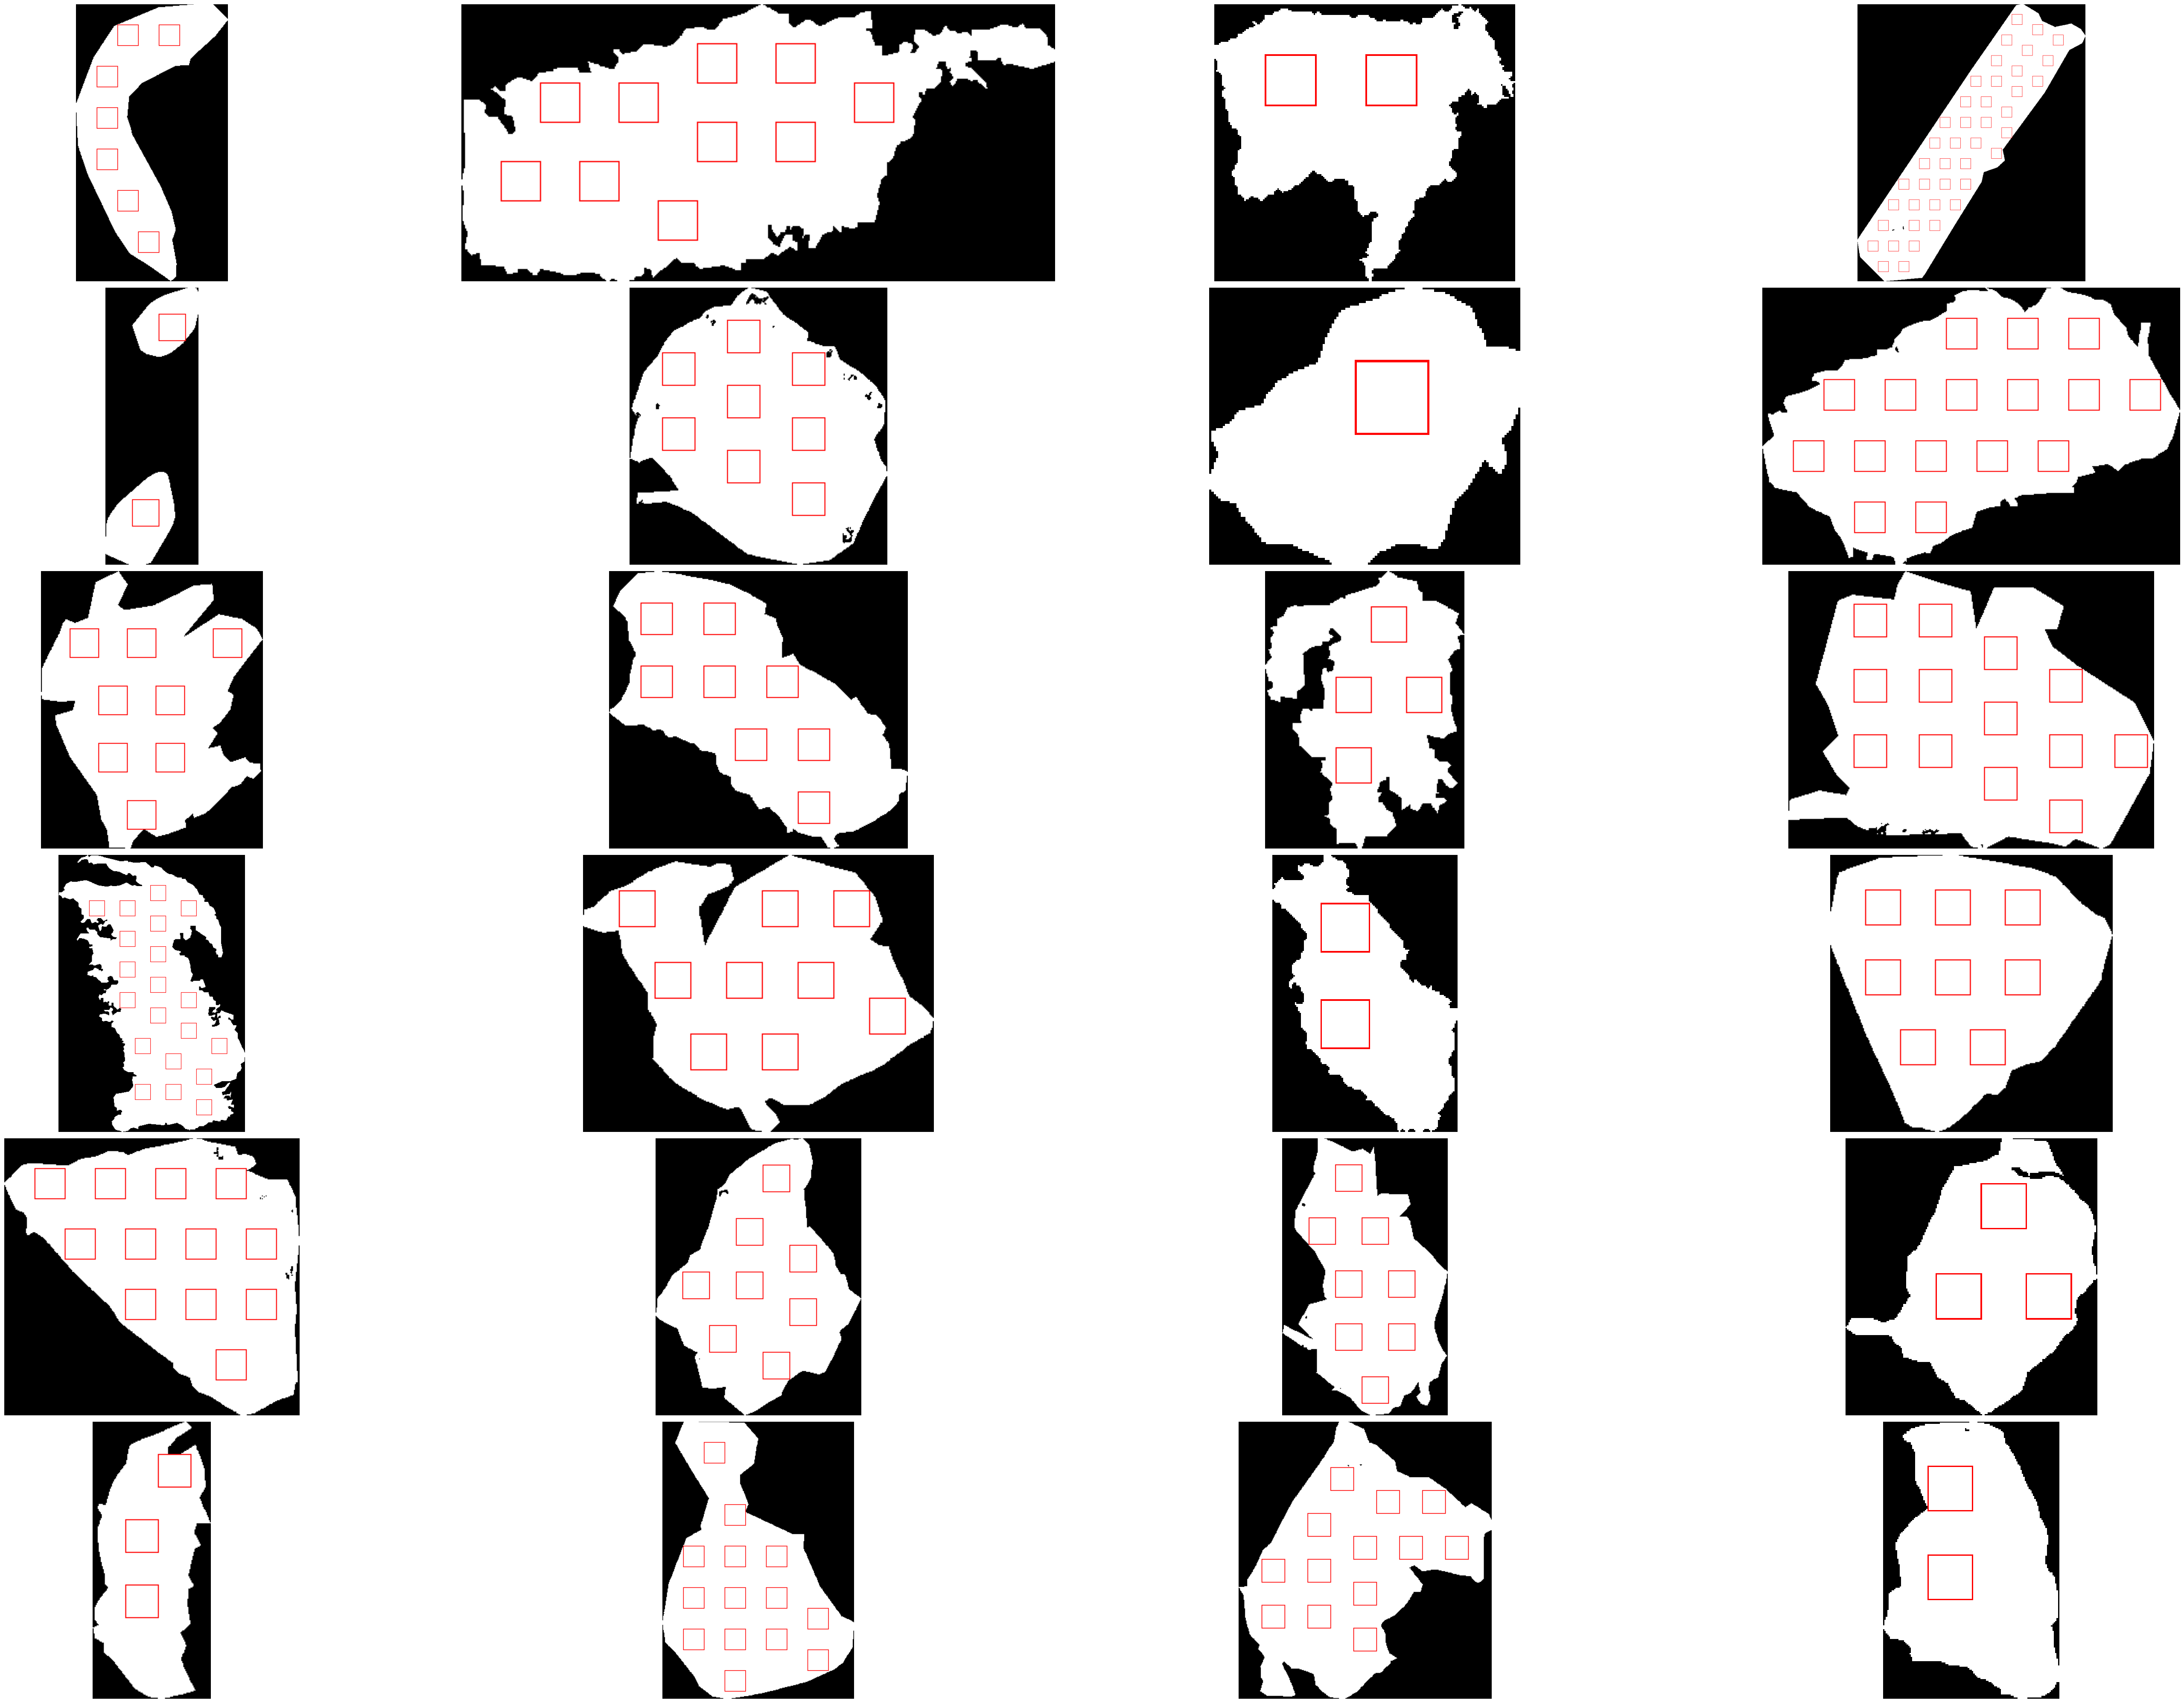

In [10]:
# display some example images and their sampled coordinates

fig, axes = plt.subplots(6, 4, figsize=(60, 40))
masks = list(dataset.masks.values())
for i, mask in enumerate(masks):
    mask = mask[:,:,0]
    coords = sample_patches_from_mask(np.array(mask), 32, 32, 1, 64)
    axes = axes.ravel()
    plot_sampled_patches(mask, coords, 32, ax=axes[i])

plt.tight_layout()
plt.show()

In [11]:


def extract_patches(image, coordinates, patch_size):
    """
    Extract patches from an image using the given coordinates.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of patches.
        patch_size (int): Size of the square patch.

    Returns:
        List[np.ndarray]: A list of extracted patches as NumPy arrays.
    """
    patches = [
        image[x_start:x_start + patch_size, y_start:y_start + patch_size]
        for x_start, y_start in coordinates
    ]
    return patches

def create_patches_by_channel(dataset, patch_size=32, stride=16, overlap=0.25, min_distance=None):
    """
    Construct a quited image dataset synthesized existing Dataset object

    Args:
        dataset: a Dataset object that contains the images
        max_patches: maximum number of patches that can be drawn on the image
        patch_size: the size of the patches
        overlap: how much two patches can overlap each other

    Returns:
        A directory containing generated quilted images
    """
    
    # for each image in the dataset, it samples patch coordinates from the mask, extracts the patches, and adds them to the appropriate dictionary based on the label.
    positive_patches_by_channel = defaultdict(list)
    negative_patches_by_channel = defaultdict(list)
    test_patches_by_channel = defaultdict(list)
    for img, label, mask, channel in dataset:
        coords = sample_patches_from_mask(np.array(mask), patch_size, stride, overlap, min_distance) # sample maximum 32 patches of size 8x8
        patches = extract_patches(np.array(img), coords, patch_size)
        if label == 1:
            positive_patches_by_channel[channel].extend(patches)
        else:
            negative_patches_by_channel[channel].extend(patches)
    return positive_patches_by_channel, negative_patches_by_channel

positive_patches, negative_patches = create_patches_by_channel(dataset, 32, 32, 1, 64)
for channel in positive_patches.keys():
    print(len(positive_patches[channel]))
    break



113


In [12]:

# sample number of patches for one channel
seed = 42

for channel in positive_patches.keys():
    # shuffle the patches with the same seed to ensure the same order of patches for each channel
    random.seed(seed)
    random.shuffle(positive_patches[channel])
    # repeat the seed so it can be applied to the negative patches
    random.seed(seed)
    random.shuffle(negative_patches[channel])



In [13]:
# NOTE: please disregard the code below, it is not used in the final pipeline

"""patch_size = 16
num_patches = (224 // patch_size) ** 2
positive_quilts_train = defaultdict(list)
positive_quilts_test = defaultdict(list)
negative_quilts_train = defaultdict(list)
negative_quilts_test = defaultdict(list)

all_channels = list(positive_patches.keys())
for channel in all_channels:
    # shuffle the patches up first
    positive_patches_train, positive_patches_test = train_test_split(positive_patches[channel], test_size= 0.3, random_state=42)
    negative_patches_train, negative_patches_test = train_test_split(negative_patches[channel], test_size= 0.3, random_state=42)

    # create numpy arrays of quilted images
    for i in range(0, len(positive_patches_train), num_patches):
        random.shuffle(positive_patches_train)
        random.shuffle(negative_patches_train)
        random.shuffle(positive_patches_test)
        random.shuffle(negative_patches_test)
        if i + num_patches <= len(positive_patches_train): # if the remaining number of patches are not enough to make a picture, ignore them

            positive_quilts_train[channel].append(quilted_np)

    for i in range(0, len(positive_patches_test), num_patches):
        if i + num_patches <= len(positive_patches_test):
            quilted_np = create_patched_image(positive_patches_test[i:i + num_patches], patch_size)
            positive_quilts_test[channel].append(quilted_np)

    for i in range(0, len(negative_patches_train), num_patches):
        if i + num_patches <= len(negative_patches_train):
            quilted_np = create_patched_image(negative_patches_train[i:i + num_patches], patch_size)
            negative_quilts_train[channel].append(quilted_np)

    for i in range(0, len(negative_patches_test), num_patches):
        if i + num_patches <= len(negative_patches_test):
            quilted_np = create_patched_image(negative_patches_test[i:i + num_patches], patch_size)
            negative_quilts_test[channel].append(quilted_np)
    """

'patch_size = 16\nnum_patches = (224 // patch_size) ** 2\npositive_quilts_train = defaultdict(list)\npositive_quilts_test = defaultdict(list)\nnegative_quilts_train = defaultdict(list)\nnegative_quilts_test = defaultdict(list)\n\nall_channels = list(positive_patches.keys())\nfor channel in all_channels:\n    # shuffle the patches up first\n    positive_patches_train, positive_patches_test = train_test_split(positive_patches[channel], test_size= 0.3, random_state=42)\n    negative_patches_train, negative_patches_test = train_test_split(negative_patches[channel], test_size= 0.3, random_state=42)\n\n    # create numpy arrays of quilted images\n    for i in range(0, len(positive_patches_train), num_patches):\n        random.shuffle(positive_patches_train)\n        random.shuffle(negative_patches_train)\n        random.shuffle(positive_patches_test)\n        random.shuffle(negative_patches_test)\n        if i + num_patches <= len(positive_patches_train): # if the remaining number of patches

In [14]:
# NOTE: please disregard the code below, it is not used in the final pipeline

"""output_folder = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/"
positive_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/positive_train/"
positive_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/positive_test/"
negative_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/negative_train/"
negative_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/negative_test/"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(positive_quilted_train, exist_ok=True)
os.makedirs(positive_quilted_test, exist_ok=True)
os.makedirs(negative_quilted_train, exist_ok=True)
os.makedirs(negative_quilted_test, exist_ok=True)
# Save each array as a grayscale image
min_train_tissues = float('inf')
min_test_tissues = float('inf')
for channel in positive_quilts_train.keys():
    min_train_tissues = min(min_train_tissues, len(positive_quilts_train[channel]), len(negative_quilts_train[channel]))
    min_test_tissues = min(min_test_tissues, len(positive_quilts_test[channel]), len(negative_quilts_test[channel]))
for channel in positive_quilts_train.keys():
    for i in range(min_train_tissues):
        img = Image.fromarray(positive_quilts_train[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(positive_quilted_train, f"Train_positive_{i}_{channel}.png"))

        img = Image.fromarray(negative_quilts_train[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(negative_quilted_train, f"Train_negative_{i}_{channel}.png"))
    for i in range(min_test_tissues):
        img = Image.fromarray(positive_quilts_test[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(positive_quilted_test, f"Test_positive_{i}_{channel}.png"))

        img = Image.fromarray(negative_quilts_test[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(negative_quilted_test, f"Test_negative_{i}_{channel}.png"))
"""

'output_folder = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/"\npositive_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/positive_train/"\npositive_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/positive_test/"\nnegative_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/negative_train/"\nnegative_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_v3/negative_test/"\nos.makedirs(output_folder, exist_ok=True)\nos.makedirs(positive_quilted_train, exist_ok=True)\nos.makedirs(positive_quilted_test, exist_ok=True)\nos.makedirs(negative_quilted_train, exist_ok=True)\nos.makedirs(negative_quilted_test, exist_ok=True)\n# Save each array as a grayscale image\nmin_train_tissues = float(\'inf\')\nmin_test_tissues = float(\'inf\')\nfor channel in positive_quilts_train.keys():\n    min_train_tissues = min(min_train_tissues, len(positive_quilts_train[channel]), len(negative_quilts_train[channe

In [15]:
# NOTE: please disregard the code below, it is not used in the final pipeline

"""output_folder = "grayscale_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Assuming you have a list of numpy arrays
numpy_arrays = [array1, array2, array3]  # Replace with your actual array list

# Save each array as a grayscale image
for i, array in enumerate(numpy_arrays):
    # Convert numpy array to PIL Image
    # Mode 'L' is for grayscale
    img = Image.fromarray(array.astype(np.uint8), mode='L')
    
    # Save the image with a sequential filename
    img.save(os.path.join(output_folder, f"image_{i}.png"))"""


'output_folder = "grayscale_images"\nif not os.path.exists(output_folder):\n    os.makedirs(output_folder)\n\n# Assuming you have a list of numpy arrays\nnumpy_arrays = [array1, array2, array3]  # Replace with your actual array list\n\n# Save each array as a grayscale image\nfor i, array in enumerate(numpy_arrays):\n    # Convert numpy array to PIL Image\n    # Mode \'L\' is for grayscale\n    img = Image.fromarray(array.astype(np.uint8), mode=\'L\')\n    \n    # Save the image with a sequential filename\n    img.save(os.path.join(output_folder, f"image_{i}.png"))'

In [27]:
# NOTE: please disregard the code below, it is not used in the final pipeline

"""class CustomQuiltedDataset(Dataset):
    def __init__(self, positive_quilts, negative_quilts, transform=None):
        self.images = []
        self.labels = []
        print(len(positive_quilts), len(negative_quilts))
        self.images.extend(positive_quilts)
        self.images.extend(negative_quilts)
        self.labels.extend([1] * len(positive_quilts))
        self.labels.extend([0] * len(negative_quilts))
        self.transform = transform
                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

quilted_dataset = CustomQuiltedDataset(positive_quilts, negative_quilts, transform=transform)
quilted_dataloader = DataLoader(quilted_dataset, batch_size=32, shuffle=True)

# Get a batch of 25 images for visualization
dataiter = iter(quilted_dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')"""

"class CustomQuiltedDataset(Dataset):\n    def __init__(self, positive_quilts, negative_quilts, transform=None):\n        self.images = []\n        self.labels = []\n        print(len(positive_quilts), len(negative_quilts))\n        self.images.extend(positive_quilts)\n        self.images.extend(negative_quilts)\n        self.labels.extend([1] * len(positive_quilts))\n        self.labels.extend([0] * len(negative_quilts))\n        self.transform = transform\n                \n    def __len__(self):\n        return len(self.images)\n\n    def __getitem__(self, idx):\n        image = Image.fromarray(self.images[idx])\n        label = self.labels[idx]  # Get the corresponding label\n        if self.transform:\n            image = self.transform(image)\n\n        return image, label  # Return both image and label\n\ntransform = transforms.Compose([\n    transforms.Resize((128, 128)),  # Resize to 128x128 pixels\n    transforms.ToTensor(),           # Convert to tensor\n])\n\nquilted_datase

In [16]:
import numpy as np
import math
from fractions import Fraction as F
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from PIL import Image, ImageDraw


class Qr3(object):
    """
    Represents a number of the form a + b*sqrt(3), where a and b are rational numbers.
    Used for exact arithmetic in the tiling construction.
    """
    def __init__(self, a: F, b: F):
        self.a = a  # Rational part
        self.b = b  # Coefficient of sqrt(3)
    
    @property
    def real(self):

        return self.a + 1.73205080757 * self.b
    
    def __float__(self):
        # allows conversion to float
        return self.real
    
    def __repr__(self):
        # string representation for debugging and display
        if self.a == 0 and self.b == 0:
            return "0"
        
        if self.b == 0:
            return str(self.a)
        
        b = "√3" if abs(self.b) == 1 else f"{abs(self.b)}√3"
        if self.a == 0:
            return b
        
        return f"{self.a} + {b}" if self.b > 0 else f"{self.a} - {b}"
    
    def __eq__(self, other):
        return self.a == other.a and self.b == other.b
    
    def __add__(self, other):
        return Qr3(self.a + other.a, self.b + other.b)
    
    def __sub__(self, other):
        return Qr3(self.a - other.a, self.b - other.b)
    
    def __mul__(self, other):
        # multiplication of two Qr3 numbers
        # (a + b√3) * (c + d√3) = (ac + 3bd) + (ad + bc)√3
        return Qr3(self.a * other.a + 3 * self.b * other.b, self.a * other.b + self.b * other.a)
    
    def __truediv__(self, other):
        # division of two Qr3 numbers using conjugate
        # (a + b√3) / (c + d√3) = [(a*c - 3*b*d) + (b*c - a*d)√3] / (c^2 - 3d^2)
        a = self.a * other.a - 3 * self.b * other.b
        b = self.b * other.a - self.a * other.b
        d = other.a**2 - 3 * other.b**2
        return Qr3(a / d, b / d)

# unit vector and rotation matrix for 30 degrees in Qr3 coordinates
ONE = np.array([Qr3(1, 0), Qr3(0, 0)])
ROT30 = np.array([[Qr3(0, F(1,2)), Qr3(F(1,2), 0)],
                  [Qr3(F(-1,2), 0), Qr3(0, F(1,2))]])

class Tile(object):
    """
    Represents a hierarchical tile, which may contain subtiles (for substitution tilings).
    """
    def __init__(self, tiles, bounds):
        self.tiles = tiles  # List of subtiles (Tile or Base)
        self.b = bounds     # Boundary points (np.array of Qr3 vectors)
        
    def add(self, dx):
        # translate the tile and all subtiles by dx
        self.b += dx
        for tile in self.tiles:
            tile.add(dx)
        return self
            
    def mul(self, M):
        # apply a linear transformation (matrix M) to the tile and all subtiles
        self.b = self.b @ M
        for tile in self.tiles:
            tile.mul(M)
        return self
            
    def copy(self):
        return Tile(
            [tile.copy() for tile in self.tiles],
            self.b.copy()
        )
            
    def flatten(self):
        # flatten the hierarchy to a list of Base tiles
        tiles = []
        for tile in self.tiles:
            tiles.extend(tile.flatten())
        return tiles
    
class Base(Tile):
    """
    Represents a base tile (leaf in the hierarchy), defined by its vertices and boundary.
    """
    def __init__(self, x, bounds):
        self.x = x      # Vertices of the tile (np.array of Qr3 vectors)
        self.b = bounds # Boundary points (np.array of Qr3 vectors)
        
    def add(self, dx):
        self.x += dx
        self.b += dx
        return self
        
    def mul(self, M):
        self.x = self.x @ M
        self.b = self.b @ M
        return self
    
    @property
    def edges(self):
        return (self.x + np.roll(self.x, 1, axis=0)) / Qr3(2, 0)
    
    def copy(self):
        return Base(self.x.copy(), self.b.copy())
        
    def flatten(self):
        return [self]

def bases(a, b):
    # edges of a single tile in (length, angle) format:
    e = [
        [a, 12], [a, 10], [b, 1], [b, 11], [a, 8], [a, 10], [b, 7],
        [b, 9], [a, 6], [a, 4], [a, 4], [a, 2], [b, 5],
    ]
    
    # get the tile coordinates
    dx = np.array([np.linalg.matrix_power(ROT30, angle) @ r for r, angle in e])
    x = np.r_[[[Qr3(0,0), Qr3(0,0)]], np.cumsum(dx, axis=0)]
    
    # quasi-boundary comes from four points
    b = x[(1, 3, 9, 13), :]
    
    # get the flipped tile
    y = x[::-1].copy()
    y[:, 1] *= Qr3(-1, 0)
    
    # move it to be flush with the original tile
    y += x[0] - y[5]
    c = y[(1, 3, 9, 13), :]
    
    # Return two base tiles: the single (H8) and the compound (H7)
    return Base(x, b), Tile([Base(x, b), Base(y, c)], b)

def supers(subtiles):
    rules = [
		[2, 2, 0, 0],
		[4, 2, 0, 0],
		[12, 1, 1, 1],
		[8, 2, 2, 0],
		[10, 2, 0, 0], 
		[12, 2, 0, 0],
    ]
    
    tiles = [subtiles[0]]
    for angle, pivot, anchor, subtile in rules:
        # rotation matrix
        M = np.linalg.matrix_power(ROT30, angle)
        
        # rotate and translate subtile
        T = subtiles[subtile].copy().mul(M)
        T.add(tiles[-1].b[anchor] - T.b[pivot])
        
        tiles.append(T)
    
    bounds = [tiles[1].b[3], tiles[2].b[0],
              tiles[4].b[3], tiles[6].b[0]]
    
    return Tile(tiles, bounds), Tile(tiles[:-1], bounds)

def neighbors(tiles):
    e = []
    for i, t1 in enumerate(tiles):
        for j, t2 in enumerate(tiles):
            if i <= j: continue
            if np.sum(np.all(t1.x[:, None, :] == t2.x, axis=-1)) >= 2:
                e.append((i, j))
    return e

def square_crop(tiles, half_width=25):
    """
    Return tiles whose centroid falls within a square window centered at the tiling center.
    half_width: half the side length of the square (i.e., square is 2*half_width wide)
    """
    if not tiles:
        return []
    G = sum(t.x.astype(float) for t in tiles).mean(axis=0) / len(tiles)

    def inside_square(t):
        centroid = t.x.astype(float).mean(axis=0)
        dx, dy = centroid - G
        return abs(dx) <= half_width and abs(dy) <= half_width

    return list(filter(inside_square, tiles))

In [36]:
TEST_PATCH_CUTOFF = 80 # cut off threshold before using the remaining patches in a channel for the testing quilts

# make directories for the positive and negative tiles
os.makedirs("../data/einstein_quilts_distance_controlled/positive", exist_ok=True)


# define parameters
output_width_px = 500
output_height_px = 500
base_dpi = 100
figsize_width_inches = output_width_px / base_dpi
figsize_height_inches = output_height_px / base_dpi

# generate tiles
H = bases(ONE, ONE) 
# apply the substitution rules multiple times to generate a larger tiling
for i in range(4): # 4 iterations generate a sufficiently complex pattern
    H = supers(H)

# flatten the hierarchy and crop the visible tiles
tiles = H[1].flatten()
tiles = square_crop(tiles, half_width=12) # crop the tiles to a square
print("Number of tiles: ", len(tiles))


for num, channel in enumerate(positive_patches.keys()):
    random_channel = 0 # random.choice([i for i in range(10)]) # chance to draw a plus sign in a channel
    fig, ax = plt.subplots(figsize=(figsize_width_inches, figsize_height_inches), constrained_layout=True)
    ax.set_aspect('equal')
    ax.set_axis_off()

    # determine overall data limits to properly set xlim/ylim for a tight, square fit
    all_vertices = np.concatenate([t.x.astype(float) for t in tiles])
    min_x_data, min_y_data = np.min(all_vertices, axis=0)
    max_x_data, max_y_data = np.max(all_vertices, axis=0)

    data_width = max_x_data - min_x_data
    data_height = max_y_data - min_y_data
    max_data_dim = max(data_width, data_height)

    buffer_factor = 1.05 
    scaled_max_data_dim = max_data_dim * buffer_factor

    center_x = (min_x_data + max_x_data) / 2
    center_y = (min_y_data + max_y_data) / 2

    ax.set_xlim(center_x - scaled_max_data_dim / 2, center_x + scaled_max_data_dim / 2)
    ax.set_ylim(center_y - scaled_max_data_dim / 2, center_y + scaled_max_data_dim / 2)
    # iterate through all tiles and fill each with a random patch
    for i, tile in enumerate(tiles):
        random_tile = random.choice([i for i in range(5)]) # chance to draw a plus sign in a tile
        vertices_float = tile.x.astype(float)
        # if there is not enough patches in the channel to fill all tiles, randomly fill the remaining tiles with duplicate patches
        if i < TEST_PATCH_CUTOFF:
            random_patch = random.choice([i for i in range(2)])
            patch_array = positive_patches[channel][i]
        # get a random patch from the source image
        else:
            patch_array = random.choice(positive_patches[channel])
        # calculate the bounding box of the current tile
        min_x, min_y = np.min(vertices_float, axis=0)
        max_x, max_y = np.max(vertices_float, axis=0)

        # create an imshow artist for the patch, with its extent set to the tile's bounding box
        # zorder=1 to place it below the outlines
        image_artist = ax.imshow(patch_array, extent=[min_x, max_x, min_y, max_y], 
                                    aspect='auto', zorder=1, cmap='gray')
        if random_channel == 100 and random_tile == 100: # draw a plus sign in 20% of the tiles in 10% of the channels
            # Draw a white plus sign at the center of the tile (zorder=2)
            center_x_tile = (min_x + max_x) / 2
            center_y_tile = (min_y + max_y) / 2
            plus_length = 0.4 * min(max_x - min_x, max_y - min_y)  # scale plus sign to tile size
            plus_half = plus_length / 2
            # draw a 1/4th of the plus sign on each channel
            if num % 4 == 0:
                ax.plot([center_x_tile - plus_half, center_x_tile],
                        [center_y_tile, center_y_tile],
                        color='white', linewidth=2, zorder=2)
            elif num % 4 == 1:
                ax.plot([center_x_tile, center_x_tile + plus_half],
                        [center_y_tile, center_y_tile],
                        color='white', linewidth=2, zorder=2)
            elif num % 4 == 2:
                # Vertical line of plus
                ax.plot([center_x_tile, center_x_tile],
                        [center_y_tile - plus_half, center_y_tile],
                        color='white', linewidth=2, zorder=2)
            elif num % 4 == 3:
                ax.plot([center_x_tile, center_x_tile],
                        [center_y_tile, center_y_tile + plus_half],
                        color='white', linewidth=2, zorder=2)

        # facecolor and edgecolor are 'none' as it's only a mask
        path_patch = PathPatch(Path(vertices_float), facecolor='none', edgecolor='none', lw=0, zorder=3)
        ax.add_patch(path_patch)

        # set the clipping path of the image to the path patch|
        image_artist.set_clip_path(path_patch)


    plt.savefig(f"../data/einstein_quilts_distance_controlled/positive/positive_{channel}.png", pad_inches=0, facecolor='black', bbox_inches='tight', dpi=100)
    plt.close(fig)

    
    

Number of tiles:  68


In [37]:
os.makedirs("../data/einstein_quilts_distance_controlled/negative", exist_ok=True)
for channel in negative_patches.keys():
   
    fig, ax = plt.subplots(figsize=(figsize_width_inches, figsize_height_inches), constrained_layout=True)
    ax.set_aspect('equal')
    ax.set_axis_off()

    # determine overall data limits to properly set xlim/ylim for a tight, square fit
    all_vertices = np.concatenate([t.x.astype(float) for t in tiles])
    min_x_data, min_y_data = np.min(all_vertices, axis=0)
    max_x_data, max_y_data = np.max(all_vertices, axis=0)

    data_width = max_x_data - min_x_data
    data_height = max_y_data - min_y_data
    max_data_dim = max(data_width, data_height)

    buffer_factor = 1.05 
    scaled_max_data_dim = max_data_dim * buffer_factor

    center_x = (min_x_data + max_x_data) / 2
    center_y = (min_y_data + max_y_data) / 2

    ax.set_xlim(center_x - scaled_max_data_dim / 2, center_x + scaled_max_data_dim / 2)
    ax.set_ylim(center_y - scaled_max_data_dim / 2, center_y + scaled_max_data_dim / 2)
    # iterate through all tiles and fill each with a random patch
    for i, tile in enumerate(tiles):
        vertices_float = tile.x.astype(float)
        # if there is not enough patches in the channel to fill all tiles, randomly fill the remaining tiles with duplicate patches
        if i < TEST_PATCH_CUTOFF:
            patch_array = negative_patches[channel][i]
        # get a random patch from the source image
        else:
            patch_array = random.choice(negative_patches[channel])
        # calculate the bounding box of the current tile
        min_x, min_y = np.min(vertices_float, axis=0)
        max_x, max_y = np.max(vertices_float, axis=0)

        # create an imshow artist for the patch, with its extent set to the tile's bounding box
        # zorder=1 to place it below the outlines
        image_artist = ax.imshow(patch_array, extent=[min_x, max_x, min_y, max_y], 
                                    aspect='auto', zorder=1, cmap='gray')

        # facecolor and edgecolor are 'none' as it's only a mask
        path_patch = PathPatch(Path(vertices_float), facecolor='none', edgecolor='none', lw=0, zorder=2)
        ax.add_patch(path_patch)

        # set the clipping path of the image to the path patch
        image_artist.set_clip_path(path_patch)


    plt.savefig(f"../data/einstein_quilts_distance_controlled/negative/negative_{channel}.png", pad_inches=0, transparent=False, bbox_inches='tight', dpi=100, facecolor='black')
    plt.close(fig)

In [38]:
from numpy import False_


def draw_and_extract_patches(img, start_x, start_y, num_rows, num_cols, window_size, draw_patches=False):
    """
    Draws red-bordered patches on the image and extracts each patch as a separate image.

    Args:
        img: numpy array of the image (H, W) or (H, W, C)
        start_x, start_y: int, top-left coordinate of the first patch
        num_rows, num_cols: int, number of rows and columns of patches
        window_size: int, size of each patch (assumed square)
        ax: matplotlib axis to draw on (if None, creates a new figure/axis)

    Returns:
        patch_images: list of numpy arrays, each corresponding to a patch
    """

    patch_images = []

        
    if draw_patches:
        fig, ax = plt.subplots()   
        ax.imshow(img, cmap='gray' if img.ndim==2 else None)
        ax.set_title(f"Channel: {channel}")
        for row in range(num_rows):
            for col in range(num_cols):
                x = start_x + col * window_size
                y = start_y + row * window_size

                # draw rectangle (patch) with red border
                rect = Rectangle((x, y), window_size, window_size, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

        plt.show()
    # extract patch (handle image boundaries)
    for row in range(num_rows):
            for col in range(num_cols):
                x = start_x + col * window_size
                y = start_y + row * window_size
                patch = img[y:y+window_size, x:x+window_size].copy()
                patch_images.append(patch)

    return patch_images


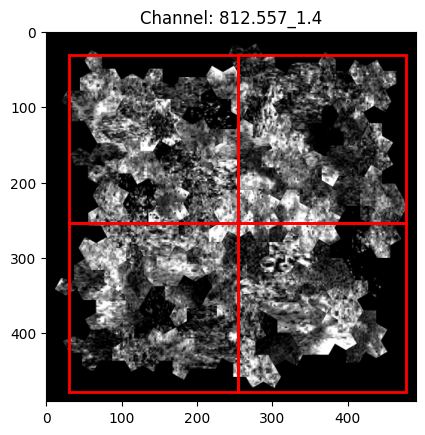

In [43]:
os.makedirs("../data/einstein_windows_distance_controlled/positive", exist_ok=True)
os.makedirs("../data/einstein_windows_distance_controlled/negative", exist_ok=True)
#os.makedirs("../data/einstein_windows_plus/negative", exist_ok=True)
draw_patches = True # only draw patches for the first image
for img in os.listdir("../data/einstein_quilts_distance_controlled/positive"):
    channel = ".".join(("_".join(img.split("_")[-2:])).split(".")[:-1])
    img = cv2.imread(f"../data/einstein_quilts_distance_controlled/positive/{img}")
    """if channel == "823.539_1.5":
        draw_patches = True"""
    patches = draw_and_extract_patches(img, start_x=30, start_y=30, num_rows=2, num_cols=2, window_size=224, draw_patches=draw_patches)
    draw_patches = False
    for i, patch in enumerate(patches):
        plt.imsave(f"../data/einstein_windows_distance_controlled/positive/{channel}_{i}.png", patch, cmap='gray' if patch.ndim==2 else None)

for img in os.listdir("../data/einstein_quilts_distance_controlled/negative"):
    channel = ".".join(("_".join(img.split("_")[-2:])).split(".")[:-1])
    img = cv2.imread(f"../data/einstein_quilts_distance_controlled/negative/{img}")
    patches = draw_and_extract_patches(img, start_x=30, start_y=30, num_rows=2, num_cols=2, window_size=224, draw_patches=draw_patches)
    draw_patches = False
    for i, patch in enumerate(patches):
        plt.imsave(f"../data/einstein_windows_distance_controlled/negative/{channel}_{i}.png", patch, cmap='gray' if patch.ndim==2 else None)

## Create test quilts and windows from tiles that are not in the training set

In [45]:
os.makedirs("../data/einstein_quilt_test_plus/positive_plus_100_intensity", exist_ok=True)
os.makedirs("../data/einstein_windows_test_plus/positive_plus_100_intensity", exist_ok=True)
# define parameters
output_width_px = 400
output_height_px = 400
base_dpi = 100
figsize_width_inches = output_width_px / base_dpi
figsize_height_inches = output_height_px / base_dpi

# generate tiles
H = bases(ONE, ONE) 
# apply the substitution rules multiple times to generate a larger tiling
for i in range(4): # 4 iterations generate a sufficiently complex pattern
    H = supers(H)

# flatten the hierarchy and crop the visible tiles
tiles = H[1].flatten()
tiles = square_crop(tiles, half_width=8) # crop the tiles to a square
print("Number of tiles: ", len(tiles))
for iter in range(20):

    for channel in positive_patches.keys():
    
        fig, ax = plt.subplots(figsize=(figsize_width_inches, figsize_height_inches), constrained_layout=True)
        ax.set_aspect('equal')
        ax.set_axis_off()

        # determine overall data limits to properly set xlim/ylim for a tight, square fit
        all_vertices = np.concatenate([t.x.astype(float) for t in tiles])
        min_x_data, min_y_data = np.min(all_vertices, axis=0)
        max_x_data, max_y_data = np.max(all_vertices, axis=0)

        data_width = max_x_data - min_x_data
        data_height = max_y_data - min_y_data
        max_data_dim = max(data_width, data_height)

        buffer_factor = 1.05 
        scaled_max_data_dim = max_data_dim * buffer_factor

        center_x = (min_x_data + max_x_data) / 2
        center_y = (min_y_data + max_y_data) / 2

        ax.set_xlim(center_x - scaled_max_data_dim / 2, center_x + scaled_max_data_dim / 2)
        ax.set_ylim(center_y - scaled_max_data_dim / 2, center_y + scaled_max_data_dim / 2)
        
        # gather the patches used for the testing quilts, and shuffle them up each time to generate a new quilted image
        test_patches_positive = positive_patches[channel][TEST_PATCH_CUTOFF:]
        test_patches_negative = negative_patches[channel][TEST_PATCH_CUTOFF:]
        # shuffle the lists to produce a new quilted image each time
        random.shuffle(test_patches_positive)
        random.shuffle(test_patches_negative)
        # iterate through all tiles and fill each with a random patch
        for i, tile in enumerate(tiles):
            random_tile = random.choice([i for i in range(1)])
            vertices_float = tile.x.astype(float)
            # if there is not enough patches in the channel to fill all tiles, randomly fill the remaining tiles with duplicate patches
            if i < len(test_patches_positive) and i < len(test_patches_negative):
                #pick = random.choice([0, 1]) # choose a random patch from either positive or negative list
                patch_array = test_patches_positive[i]
            # get a random patch from the source image
            else:
                #pick = random.choice([0, 1]) # choose a random patch from either positive or negative list
                patch_array = random.choice(positive_patches[channel]) #if pick == 1 else random.choice(negative_patches[channel])
            # calculate the bounding box of the current tile
            min_x, min_y = np.min(vertices_float, axis=0)
            max_x, max_y = np.max(vertices_float, axis=0)

            image_artist = ax.imshow(patch_array, extent=[min_x, max_x, min_y, max_y], 
                                    aspect='auto', zorder=1, cmap='gray')

            # draw a white plus sign at the center of the tile (zorder=2)
            center_x_tile = (min_x + max_x) / 2
            center_y_tile = (min_y + max_y) / 2
            # draw a plus sign based on random chance
            if random_tile == 0:
                plus_length = 0.4 * min(max_x - min_x, max_y - min_y)  # scale plus sign to tile size
                plus_half = plus_length / 2

                # horizontal line of plus
                ax.plot([center_x_tile - plus_half, center_x_tile + plus_half],
                        [center_y_tile, center_y_tile],
                        color='white', linewidth=2, zorder=2)
                # Vertical line of plus
                ax.plot([center_x_tile, center_x_tile],
                        [center_y_tile - plus_half, center_y_tile + plus_half],
                        color='white', linewidth=2, zorder=2)

            # facecolor and edgecolor are 'none' as it's only a mask
            path_patch = PathPatch(Path(vertices_float), facecolor='none', edgecolor='none', lw=0, zorder=3)
            ax.add_patch(path_patch)


            # set the clipping path of the image to the path patch
            image_artist.set_clip_path(path_patch)


        plt.savefig(f"../data/einstein_quilt_test_plus/positive_plus_100_intensity/testing_{channel}_{iter}.png", pad_inches=0, facecolor='black', bbox_inches='tight', dpi=100)
        plt.close(fig)

    draw_patches = True # only draw patches for the first image
    img_list = [img for img in os.listdir("../data/einstein_quilt_test_plus/positive_plus_100_intensity") if img.endswith(f"_{iter}.png")]
    for img_path in img_list:
        channel = "_".join(img_path.split("_")[1:-1])
        img = cv2.imread(f"../data/einstein_quilt_test_plus/positive_plus_100_intensity/{img_path}")
        patches = draw_and_extract_patches(img, start_x=50, start_y=50, num_rows=1, num_cols=1, window_size=224, draw_patches=False)
        plt.imsave(f"../data/einstein_windows_test_plus/positive_plus_100_intensity/{channel}_{iter}.png", patches[0], cmap='gray' if patches[0].ndim==2 else None)

Number of tiles:  31


### Quilt generation for dataset at 10SNR

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert to tensor

])

# create dataset and dataloader
folder_path = '../data/images_10snr_aligned/'
dataset = SingleChannelDataset(folder_path, transform=None)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
positive_patches, negative_patches, random_patch_indices = create_patches_by_channel(dataset, 32, 32, 1)


dict_keys(['846.527_1.4', '825.552_1.4', '820.515_1.4', '739.453_1.4', '849.558_1.5'])
dict_keys(['820.515_1.4', '825.552_1.4', '849.558_1.5', '846.527_1.4', '739.453_1.4'])


In [18]:
# sample number of patches for one channel
seed = 42
random.seed(seed)
positive_indices = [i for i in range(len(positive_patches))]
random.shuffle(positive_indices)
positive_patch_indices = [positive_indices.index(i) for i in random_patch_indices]
seed = 42
negative_indices = [i for i in range(len(negative_patches))]
random.shuffle(negative_indices)

ValueError: 42 is not in list